# Text to Speech

When solving some problem with deep learning in practice, you search the Web for the latest paper that solves that task, and take its implementation from GitHub. However, often there is no code, so being able to **reimplement a paper** is a vital skill. You will likely have to do it in your course project, and we are going to practice it in this assignment.

Let's focus on the task of text-to-speech (**TTS**) synthesis.

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

## Data

 Intuitively, in the real world your dataset would be a set of pairs:

* text (string);
* **target**: raw audio of a person saying `text` (array of amplitude values sampled e.g. 44100 times per second — see an example plotted above).

We give you a simplified problem statement, with one dataset sample being an utterance described by

* list of [ARPAbet phonemes](http://www.speech.cs.cmu.edu/cgi-bin/cmudict#phones);
* *phoneme alignment*, i.e. start time (frame) and duration for each phoneme;
* **target**: [mel spectrogram](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MelSpectrogram) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

In [0]:
import scipy.io.wavfile

import torch
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import random
from pathlib import Path

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 4")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ![ ! -d "LJ-Speech-aligned" ] && unzip -q "{AUX_DATA_ROOT / 'LJ-Speech-aligned.zip'}"
!![ ! -d "LJ-Speech-aligned" ] && unzip -q "{AUX_DATA_ROOT.parent / 'LJ-Speech-aligned.zip'}"
!git clone --recursive https://github.com/shrubb/waveglow.git -b denoiser-fix
!wget -c https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt

fatal: destination path 'waveglow' already exists and is not an empty directory.
--2020-05-24 20:11:27--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.201.137, 35.161.182.61
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.201.137|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://s3.us-west-2.amazonaws.com/prod-model-registry-ngc-bucket/org/nvidia/models/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt?response-content-disposition=attachment%3B%20filename%3D%22waveglow_256channels_ljs_v2.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjECMaCXVzLXdlc3QtMiJHMEUCIFo8sQIMBbRU1RDVcE73rVV6IRwaIih90MvI6anB%2FME%2BAiEA1aefTgWrN5vB94FRCW0zFBsJ7GLjE5VTHIRYlN2WBJQqtAMIfBACGgw3ODkzNjMxMzUwMjciDGVTWsj2aWtFEqxeVyqRA4Bdui2GXQ2mm8%2BkBg0dNtvzHEoC1nQWF1CPpWtFqdQXq2Z

Use this Python module to handle our dataset. It's documented, so when in doubt, use `help()` or read the code with `??lj_speech`.

In [4]:
!pip install git+https://github.com/shrubb/listener.git

  Cloning https://github.com/shrubb/listener.git to /tmp/pip-req-build-zm0fezzk
  Running command git clone -q https://github.com/shrubb/listener.git /tmp/pip-req-build-zm0fezzk
  Created wheel for listener: filename=listener-1.0.0a1-cp36-none-any.whl size=87098 sha256=241358fe47f5547491b120d4967db73f9f12ac815d20a42c221f292233c8f9ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ph1r9r8/wheels/41/ec/98/7c89227ba5da35ff1e7d5284bb58e0b98e93389fc1f77c407b
Successfully built listener


In [0]:
import lj_speech

In [0]:
DATASET_ROOT = Path('LJ-Speech-aligned/')

train_dataset, val_dataset = lj_speech.get_dataset(DATASET_ROOT)

There are also a couple of useful constants, check them with `?lj_speech`.

In [7]:
len(lj_speech.POSSIBLE_PHONEME_CODES)

54

Here is an example datapoint:

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram


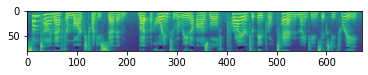

In [8]:
example_datapoint = train_dataset[666]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
plt.imshow(example_datapoint['spectrogram']);

To "play" spectrograms, including those that you will generate, we will use another deep learning algorithm called [WaveGlow](https://arxiv.org/abs/1811.00002). It converts mel spectrograms to audio.

Fortunately, there *is* code for it on GitHub, so you won't have to reimplement it 🙂 Still, if you haven't done so, I encourage you to watch a short [video](https://www.youtube.com/watch?v=CqFIVCD1WWo) about a famous paper that it's based on.

In [0]:
vocoder = lj_speech.Vocoder()

In [10]:
print(example_datapoint['text'])

example_spectrogram = torch.from_numpy(example_datapoint['spectrogram'])
audio = vocoder(example_spectrogram)
lj_speech.play_audio(audio)

sometime after march twenty-seven, but according to marina oswald, prior to april ten, nineteen sixty-three,


Finally, we have phonemes as inputs, but we'd like to synthesize arbitrary text. For that, there is a function `lj_speech.text_to_phonemes(text)`.

## Method

Reimplement the baseline method defined by the diagram below. It's derived from a simplified version of the [DurIAN paper](https://arxiv.org/abs/1909.01700).

Just in case, here are some of the most notable differences from DurIAN:
* Prosodic boundary markers aren't used (we don't have them labeled), and thus there's no 'skip states' exclusion of prosodic boundaries' hidden states.
* Style codes aren't used too (same).
* Simpler network architectures.
* No pre-net in decoder.
* No attention used in decoder.
* Decoder's recurrent cell outputs single spectrogram frame at a time.
* Decoder's recurrent cell isn't conditioned on its own outputs (isn't "autogressive").

![pipeline](https://user-images.githubusercontent.com/9570420/81863803-6f0ba300-9574-11ea-9f02-481c2bba81f0.png)

This picture is the simplified Figure 1 from the paper. **Use the paper as a reference**. If something is unclear from the diagram — and, in fact, some things are intentionally omitted — search answers in the paper (but remain aware of the differences/simplifications in the above diagram) and other papers that the authors cite. There will even be details that aren't even mentioned anywhere in the paper, so you'll have to guess by your intuition. For instance, DurIAN paper doesn't explain batch size and sampling strategy, and even if it did, it would be irrelevant since we use different data. Finally, search the Web and read others' code; however, if you copy-paste code, **cite it**.

Tips:
* Only compute loss on the 'original' parts of the spectrograms (don't include padding)!
* When using recurrent nets, [clip gradients' norm](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_).
* Since you will use recurrent nets, and the sequences in a batch will be of different lengths, you may find [sequence packing utility](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) useful.
* Remember that you can send images and audio into TensorBoard, too.

**Train this baseline so that the words are well-recognizable, and try to get rid of the "metallic", "tin sounding" voice.**

**Aim for something like this:**

In [11]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'ok.wav')[1])

**On the other hand, here is an example of insufficient quality:**

In [12]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'bad.wav')[1])

## Improving the Method

When you have the baseline working, seek the ways to improve quality and to decrease loss. Look into the paper and the relevant/neighbouring literature. Also, follow your intuition, e.g. for changing model complexity or regularization. For example, you can (but aren't obliged to) try borrowing more tricks from DurIAN; a couple of examples for inspiration:

* Make decoder recurrent cell autoregressive as in the paper: use its output as its input at the next preiction step.
* Add pre-net to decoder.
* Add attention to decoder.
* Use more complex sub-network architectures (e.g. use CBHG).
* Employ tricks from Tacotron {[1](https://arxiv.org/abs/1703.10135),[2](https://arxiv.org/abs/1712.05884)} — papers that DurIAN is based upon, e.g. [zoneout](https://arxiv.org/abs/1606.01305) in RNNs.

Write a report on your journey to better loss. Explain if you managed to perceptibly improve the quality and lower the loss, what you tried and why, what worked and what didn't. Include TensorBoard loss plots.

## Deliverables

1. This file, fully functional, reproducing all the reported results on "Run all". Out-of-the box `TextToSpeechSynthesizer` class (see interface below) and demo code of running it on arbitrary text.
2. Report on improving the baseline at the end of this file.
3. Two "checkpoint files" with weights for both of your models (baseline and the improved model).

## Grading

* **[7 points]** Baseline.
* **[3 points]** Improving of the baseline.

## Baseline

### Imports, setup and handy functions

In [0]:
import os
from datetime import datetime
from torch import nn
from torch.utils.tensorboard import SummaryWriter

Handy function for setting up experiments with Tensorboard logging. By default all the Tensorboard logs will be stored in ./tb dir

In [0]:
def setup_experiment(title, logdir="./tb"):
    experiment_name = "{}@{}".format(title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
    writer = SummaryWriter(log_dir=os.path.join(logdir, experiment_name))
    best_model_path = f"{title}.best.pth"
    return writer, experiment_name, best_model_path

Model parameters counter

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Vocabulary Building

In [0]:
lj_speech.POSSIBLE_PHONEME_CODES

def build_vocab(phoneme_codes):
    sorted_phoneme_codes = ['<pad>'] + sorted(phoneme_codes)
    vocab = {}
    for i, phoneme_code in enumerate(sorted_phoneme_codes):
        vocab[phoneme_code] = i
    
    return vocab

def stoi(vocab, phonemes_sequence):
    return [vocab[phoneme_code] for phoneme_code in phonemes_sequence]

phoneme_vocab = build_vocab(lj_speech.POSSIBLE_PHONEME_CODES)

Constants Setting

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

BATCH_SIZE = 128
INPUT_DIM = len(phoneme_vocab)
OUTPUT_DIM = example_datapoint['spectrogram'].shape[0]

Device: cuda


### Data Preparation

In [0]:
def collate(batch):
    phonemes = [torch.tensor(stoi(phoneme_vocab, item['phonemes_code']), dtype=torch.int64).to(device) for item in batch]
    durations = [torch.tensor(item['phonemes_duration'], dtype=torch.int64).to(device) for item in batch]
    spectrograms = [torch.tensor(item['spectrogram'], dtype=torch.int64).to(device) for item in batch]
    
    return [phonemes, durations, spectrograms]

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=collate)

### Phoneme Embeddings

In [0]:
class PhonemeEmbedding(nn.Module):
    def __init__(self, input_dim, hid_dim=256):
        super().__init__()

        # embedding
        self.phoneme_embedding = nn.Embedding(input_dim, hid_dim)
    
    def forward(self, phonemes):
        """
        phonemes (batch of sequences of phonemes): list of torch.float32 tensors of shapes [seq_len[i]]
        
        returns (batch of sequences of phoneme embeddings): torch.float32 tensor of shape [bs, max_seq_len, hid_dim]
        """
        return self.phoneme_embedding(nn.utils.rnn.pad_sequence(phonemes, batch_first=True))

### 1D Conv Residual Block

In [0]:
class conv_residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, dropout=0.5):
        super().__init__()

        self.complex_conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2),
                                          nn.ReLU(),
                                          nn.BatchNorm1d(out_channels),
                                          nn.Dropout(dropout))
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

        # custom weight initialization
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
    
    def forward(self, x):
        """
        x (batch of sequences of vectors): torch.float32 tensor of shape [bs, seq_len, in_channels]
        
        returns (processed batch of sequences of vectors): torch.float32 tensor of shape [bs, seq_len, out_channels]
        """
        x = x.transpose(-2, -1)
        return (self.complex_conv(x) + self.conv(x)).transpose(-2, -1)

### Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, hid_dim=256, output_hid_dim=512):
        super().__init__()

        assert output_hid_dim % 2 == 0, "output_hid_dim must be divisible by 2"
        
        # conv blocks
        self.conv_block_small = nn.Sequential(conv_residual_block(in_channels=hid_dim, out_channels=256),
                                              conv_residual_block(256, 256))
        
        self.conv_block_large = nn.Sequential(conv_residual_block(in_channels=256, out_channels=512),
                                              conv_residual_block(512, 512),
                                              conv_residual_block(512, 512))
        
        # bi-GRU
        self.bi_gru = nn.GRU(input_size=512, hidden_size=output_hid_dim//2,
                             batch_first=True, bidirectional=True)
        
        # custom weight initialization
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
        
    def forward(self, phoneme_embeddings):
        """
        phoneme_embeddings (batch of sequences of phoneme embeddings): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        
        returns (hidden representations of phonemes): torch.float32 tensor of shape [bs, seq_len, output_hid_dim]
        """
        x = self.conv_block_large(self.conv_block_small(phoneme_embeddings))
        
        return self.bi_gru(x)[0]

### Duration Model

In [0]:
class DurationModel(nn.Module):
    def __init__(self, hid_dim, output_hid_dim=512):
        super().__init__()
        
        assert output_hid_dim % 2 == 0, "output_hid_dim must be divisible by 2"

        # bi-LSTM
        self.bi_lstm = nn.LSTM(input_size=hid_dim, hidden_size=output_hid_dim//2, num_layers=3,
                               batch_first=True, bidirectional=True)

        # dense layer
        self.fc = nn.Linear(output_hid_dim, 1)
        
        # custom weight initialization
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
    
    def forward(self, phoneme_embeddings):
        """
        phoneme_embeddings (batch of sequences of phoneme embeddings): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        
        returns (predicted durations): torch.int64 tensor of shape [bs, seq_len]
        """
        x = self.bi_lstm(phoneme_embeddings)[0]
        
        return self.fc(x).squeeze(-1)

### Alignment Model

In [0]:
class AlignmentModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def replicate(self, hid_phonemes, durations):
        device = durations.device
        replicated_phonemes = []
        for batch_item in range(hid_phonemes.shape[0]):
            positions = []
            for i, duration in enumerate(durations[batch_item, :]):
                positions.append(torch.linspace(0, 1, duration))
            replicated_phonemes.append(torch.cat([torch.cat(positions, dim=0).unsqueeze(1).to(device),
                                                  hid_phonemes[batch_item, ...].repeat_interleave(durations[batch_item, :], dim=0)], dim=1))
        return replicated_phonemes
    
    def forward(self, hid_phonemes, durations):
        """
        hid_phonemes (hidden representations of phonemes): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        durations (ground truth or predicted durations): torch.int64 tensor of shape [bs, seq_len]
        
        returns (aligned representations of phonemes): list of torch.float32 tensors of shapes [durations.sum(dim=1)[i], hid_dim + 1]
        """
        return self.replicate(hid_phonemes, durations) 

### Post Net

In [0]:
class PostNet(nn.Module):
    def __init__(self, output_dim, hid_dim=256):
        super().__init__()

        # conv block
        self.conv_block = nn.Sequential(conv_residual_block(in_channels=hid_dim, out_channels=256, dropout=0.0),
                                        conv_residual_block(256, 256, dropout=0.0),
                                        conv_residual_block(256, 256, dropout=0.0),
                                        conv_residual_block(256, 256, dropout=0.0),
                                        conv_residual_block(256, 256, dropout=0.0))
        
        self.conv = nn.Conv1d(256, output_dim, kernel_size=1)

        # custom weight initialization
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
    
    def forward(self, hid_aligned_phonemes):
        """
        hid_aligned_phonemes (hidden aligned representations of phonemes): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        
        returns (predicted residual): torch.float32 tensor of shape [bs, output_dim, seq_len])
        """
        return self.conv(self.conv_block(hid_aligned_phonemes).transpose(-2, -1))

### Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, output_hid_dim=256):
        super().__init__()

        assert output_hid_dim % 2 == 0, "output_hid_dim must be divisible by 2"
        
        # GRU
        self.gru = nn.GRU(input_size=hid_dim, hidden_size=output_hid_dim, num_layers=2,
                          batch_first=True, bidirectional=False)

        # conv
        self.conv = nn.Conv1d(output_hid_dim, output_dim, kernel_size=1)

        # post net
        self.post_net = PostNet(output_dim)
        
        # custom weight initialization
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
        
    def forward(self, aligned_phonemes):
        """
        aligned_phonemes (aligned representations of phonemes): list of torch.float32 tensors of shapes [seq_len[i], hid_dim]
        
        returns pair<predicted spectrogram, predicted residual>: (torch.float32 tensor of shape [bs, output_dim, seq_len.sum(dim=0)],
                                                                  torch.float32 tensor of shape [bs, output_dim, seq_len.sum(dim=0)])
        """
        x = nn.utils.rnn.pack_sequence(aligned_phonemes, enforce_sorted=False)
        x = self.gru(x)[0]
        x = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)[0]
        
        return (self.conv(x.transpose(-2, -1)), self.post_net(x))

### Phonemes To Speech Model

In [0]:
class PhonemesToSpeech(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim=256, output_hid_dim=512):
        super().__init__()

        assert output_hid_dim % 2 == 0, "output_hid_dim must be divisible by 2"
        
        self.phoneme_embedding = PhonemeEmbedding(input_dim, hid_dim)
        self.encoder = Encoder(hid_dim, output_hid_dim)
        self.duration_model = DurationModel(hid_dim, output_hid_dim)
        self.alignment = AlignmentModel()
        self.decoder = Decoder(output_dim, output_hid_dim + 1, output_hid_dim//2)
        
    def forward(self, phonemes, durations=None):
        """
        phonemes (batch of sequences of phonemes): list of torch.float32 tensors of shapes [seq_len[i]]
        durations (ground truth or predicted durations): torch.int64 tensor of shape [bs, seq_len]
                 --default: None
        
        returns pair<predicted spectrogram, predicted residual>: (torch.float32 tensor of shape [bs, output_dim, seq_len.sum(dim=0)],
                                                                  torch.float32 tensor of shape [bs, output_dim, seq_len.sum(dim=0)])
        """
        phoneme_embeddings = self.phoneme_embedding(phonemes)
        hid_phonemes = self.encoder(phoneme_embeddings)
        predicted_durations = self.duration_model(phoneme_embeddings)
        if durations is not None:
            aligned_phonemes = self.alignment(hid_phonemes, nn.utils.rnn.pad_sequence(durations, batch_first=True))
        else:
            aligned_phonemes = self.alignment(hid_phonemes, predicted_durations.to(dtype=torch.int64))
        
        return self.decoder(aligned_phonemes), predicted_durations

## Model Training

In [0]:
from tqdm.notebook import tqdm

def run_epoch(model, iterator,
              spectrograms_criterion, durations_criterion,
              optimizer,
              phase='train',
              epoch=0,
              writer=None):
    is_train = (phase == 'train')
    if is_train:
        model.train()
    else:
        model.eval()
    
    epoch_spectrograms_loss = 0
    epoch_durations_loss = 0
    
    with torch.set_grad_enabled(is_train):
        for i, (phonemes, durations, spectrograms) in enumerate(tqdm(iterator)):
            global_i = len(iterator) * epoch + i
            
            # make prediction
            predicted_spectrograms, predicted_durations = model(phonemes, durations)
            
            # calculate losses
            spectrograms_loss = spectrograms_criterion(predicted_spectrograms, spectrograms)
            durations_loss = durations_criterion(predicted_durations, durations)
            
            if is_train:
                # make optimization step
                optimizer.zero_grad()
                spectrograms_loss.backward(retain_graph=True)
                durations_loss.backward()
                optimizer.step()
                
            epoch_spectrograms_loss += spectrograms_loss.item()
            epoch_durations_loss += durations_loss.item()

        # dump epoch metrics to tensorboard
        if writer is not None:
            writer.add_scalar(f"spectrograms_loss_epoch/{phase}", epoch_spectrograms_loss / len(iterator), epoch)
            writer.add_scalar(f"durations_loss_epoch/{phase}", epoch_durations_loss / len(iterator), epoch)

        return epoch_spectrograms_loss / len(iterator), epoch_durations_loss / len(iterator)

### Loss Functions

In [0]:
class L1Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.loss = nn.L1Loss()
    
    def forward(self, spectrograms, gt_spectrogram):
        loss = 0.0
        for batch_item in range(len(gt_spectrogram)):
            w = min(spectrograms[0][batch_item].shape[1], gt_spectrogram[batch_item].shape[1])
            loss += self.loss(spectrograms[0][batch_item, :, :w],
                              gt_spectrogram[batch_item][:, :w])

            w = min(spectrograms[1][batch_item].shape[1], w)
            loss += self.loss(spectrograms[0][batch_item, :, :w] + spectrograms[1][batch_item, :, :w],
                              gt_spectrogram[batch_item][:, :w])
        
        return loss

class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.loss = nn.MSELoss()
    
    def forward(self, durations, gt_durations):
        loss = 0.0
        for batch_item in range(len(gt_durations)):
            n = gt_durations[batch_item].shape[0]
            loss += self.loss(durations[batch_item, :n].to(dtype=torch.float32),
                              gt_durations[batch_item].to(dtype=torch.float32))
        
        return loss/len(gt_durations)

### Gradient Norms Clipping

In [0]:
def clip_rnn_gradients(model):
    max_norm = 1
    nn.utils.clip_grad_norm_(model.encoder.bi_gru.parameters(), max_norm, norm_type=2)
    nn.utils.clip_grad_norm_(model.duration_model.bi_lstm.parameters(), max_norm, norm_type=2)
    nn.utils.clip_grad_norm_(model.decoder.gru.parameters(), max_norm, norm_type=2)

## Baseline Model Training

setup of model, optimizier and experiment:

In [0]:
hid_dim = 256
output_hid_dim = 512

model = PhonemesToSpeech(INPUT_DIM, OUTPUT_DIM, hid_dim, output_hid_dim).to(device)

In [31]:
spectrograms_criterion = L1Loss()
durations_criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

writer, experiment_name, best_model_path = setup_experiment(model.__class__.__name__, logdir="./tb")
print(f"Experiment name: {experiment_name}")

print(f"Model has {count_parameters(model):,} trainable parameters")

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Experiment name: PhonemesToSpeech@24.05.2020-18:26:42
Model has 13,129,889 trainable parameters


In [33]:
n_epochs = 10

best_val_loss = float('+inf')
for epoch in range(n_epochs):
    train_spectrograms_loss, train_durations_loss = run_epoch(model, train_dataloader,
                                                              spectrograms_criterion, durations_criterion,
                                                              optimizer,
                                                              phase='train',
                                                              epoch=epoch,
                                                              writer=writer)
    val_spectrograms_loss, val_durations_loss = run_epoch(model, val_dataloader,
                                                          spectrograms_criterion, durations_criterion,
                                                          None,
                                                          phase='val',
                                                          epoch=epoch,
                                                          writer=writer)
    # clip_rnn_gradients(model)
    
    val_loss = val_spectrograms_loss + val_durations_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Spectrograms Loss: {train_spectrograms_loss:.3f} | Train Durations Loss: {train_durations_loss:.3f}')
    print(f'\t Val. Spectrograms Loss: {val_spectrograms_loss:.3f} |  Val. Durations Loss: {val_durations_loss:.3f}') 


Epoch: 01
	Train Spectrograms Loss: 373.164 | Train Durations Loss: 17.431
	 Val. Spectrograms Loss: 220.319 |  Val. Durations Loss: 8.267



Epoch: 02
	Train Spectrograms Loss: 254.176 | Train Durations Loss: 8.451
	 Val. Spectrograms Loss: 192.759 |  Val. Durations Loss: 6.691



Epoch: 03
	Train Spectrograms Loss: 231.708 | Train Durations Loss: 7.598
	 Val. Spectrograms Loss: 176.639 |  Val. Durations Loss: 6.421



Epoch: 04
	Train Spectrograms Loss: 223.081 | Train Durations Loss: 7.233
	 Val. Spectrograms Loss: 176.032 |  Val. Durations Loss: 6.269



Epoch: 05
	Train Spectrograms Loss: 218.810 | Train Durations Loss: 6.906
	 Val. Spectrograms Loss: 170.199 |  Val. Durations Loss: 6.148



Epoch: 06
	Train Spectrograms Loss: 215.734 | Train Durations Loss: 6.640
	 Val. Spectrograms Loss: 167.918 |  Val. Durations Loss: 6.152



Epoch: 07
	Train Spectrograms Loss: 213.568 | Train Durations Loss: 6.392
	 Val. Spectrograms Loss: 167.296 |  Val. Durations Loss: 6.009



Epoch: 08
	Train Spectrograms Loss: 212.017 | Train Durations Loss: 6.163
	 Val. Spectrograms Loss: 165.819 |  Val. Durations Loss: 6.290



Epoch: 09
	Train Spectrograms Loss: 210.657 | Train Durations Loss: 5.905
	 Val. Spectrograms Loss: 164.215 |  Val. Durations Loss: 6.099



Epoch: 10
	Train Spectrograms Loss: 209.615 | Train Durations Loss: 5.635
	 Val. Spectrograms Loss: 163.070 |  Val. Durations Loss: 6.133


## Inference

In [0]:
class TextToSpeechSynthesizer(object):
    """
    When done, please fill this class. It should work out-of-the-box, i.e.
    have a simple interface, automatically load model weights,
    process text to speech at one command without errors etc.
    """
    def __init__(self, inference_model, checkpoint_path, device):
        """
        Initialize anything you may need. For example, load model weights from disk.
        """
        self.device = device

        self.model = inference_model
        self.model.load_state_dict(torch.load(checkpoint_path))
        self.model.to(self.device)
        self.model.eval()
    
    def synthesize_from_text(self, text):
        """
        Synthesize text into voice.

        text:
            str
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        phonemes = lj_speech.text_to_phonemes(text)
        return self.synthesize_from_phonemes(phonemes)

    def synthesize_from_phonemes(self, phonemes, durations=None):
        """
        Synthesize phonemes into voice.

        phonemes:
            list of str
            ARPAbet phoneme codes.
        durations:
            list of int, optional
            Duration in spectrogram frames for each phoneme.
            If given, will be used for hard alignment in the model (like during
            training); otherwise, durations will be predicted by the duration
            model.
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        # Your code here
        with torch.no_grad():
            spectrogram = self.model(torch.tensor(stoi(phoneme_vocab, phonemes), dtype=torch.int64).unsqueeze(0).to(self.device),
                                     durations)[0][0]
        return vocoder(spectrogram)

In [0]:
# Example:
hid_dim = 256
output_hid_dim = 512
model_path = '/content/PhonemesToSpeech.best.pth'
synthesizer = TextToSpeechSynthesizer(PhonemesToSpeech(INPUT_DIM, OUTPUT_DIM, hid_dim, output_hid_dim), model_path, device)

In [41]:
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    synthesizer.synthesize_from_phonemes(phonemes))

## Baseline Model Results

In [42]:
# text = "Pack my box with five dozen liquor jugs."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
text = "Last homework. We are in a deep trouble. No sleep tonight."

lj_speech.play_audio(
    synthesizer.synthesize_from_text(text))

## Improving The Model

### Pre-Net

In [0]:
class Prenet(nn.Module):
    def __init__(self, input_dim=256, output_dim=64, dropout=0.5):
        super().__init__()

        self.prenet = nn.Sequential(nn.Linear(input_dim, 128),
                                    nn.ReLU(),
                                    nn.Dropout(dropout),
                                    nn.Linear(128, output_dim),
                                    nn.ReLU(),
                                    nn.Dropout(dropout))

    def forward(self, phonemes):
        """
        phonemes (batch of sequences of phonemes): torch.float32 tensor of shape [bs, seq_len, input_dim]
        
        returns (processed batch of sequences of phonemes): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        return self.prenet(phonemes)

### Improving Phonemes To Speech Model

In [0]:
class ImprovingPhonemesToSpeech(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim=256, output_hid_dim=512):
        super().__init__()

        assert output_hid_dim % 2 == 0, "output_hid_dim must be divisible by 2"
        
        self.phoneme_embedding = PhonemeEmbedding(input_dim, hid_dim)
        self.encoder = Encoder(hid_dim, output_hid_dim)
        self.duration_model = DurationModel(hid_dim, output_hid_dim)
        self.alignment = AlignmentModel()
        self.decoder_prenet = Prenet(input_dim=output_hid_dim + 1, output_dim=64)
        self.decoder = Decoder(output_dim, 64, output_hid_dim//2)
        
    def forward(self, phonemes, durations=None):
        """
        phonemes (batch of sequences of phonemes): list of torch.float32 tensors of shapes [seq_len[i]]
        durations (ground truth or predicted durations): torch.int64 tensor of shape [bs, seq_len]
                 --default: None
        
        returns pair<predicted spectrogram, predicted residual>: (torch.float32 tensor of shape [bs, output_dim, seq_len.sum(dim=0)],
                                                                  torch.float32 tensor of shape [bs, output_dim, seq_len.sum(dim=0)])
        """
        phoneme_embeddings = self.phoneme_embedding(phonemes)
        hid_phonemes = self.encoder(phoneme_embeddings)
        predicted_durations = self.duration_model(phoneme_embeddings)
        if durations is not None:
            aligned_phonemes = self.alignment(hid_phonemes, nn.utils.rnn.pad_sequence(durations, batch_first=True))
        else:
            aligned_phonemes = self.alignment(hid_phonemes, predicted_durations.to(dtype=torch.int64))
        
        return self.decoder(self.decoder_prenet(nn.utils.rnn.pad_sequence(aligned_phonemes, batch_first=True))), predicted_durations

## Improving Model Training

In [0]:
hid_dim = 256
output_hid_dim = 512

model = ImprovingPhonemesToSpeech(INPUT_DIM, OUTPUT_DIM, hid_dim, output_hid_dim).to(device)

In [35]:
spectrograms_criterion = L1Loss()
durations_criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

writer, experiment_name, best_model_path = setup_experiment(model.__class__.__name__, logdir="./tb")
print(f"Experiment name: {experiment_name}")

print(f"Model has {count_parameters(model):,} trainable parameters")

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Experiment name: ImprovingPhonemesToSpeech@24.05.2020-20:12:15
Model has 12,859,105 trainable parameters


In [36]:
n_epochs = 10

best_val_loss = float('+inf')
for epoch in range(n_epochs):
    train_spectrograms_loss, train_durations_loss = run_epoch(model, train_dataloader,
                                                              spectrograms_criterion, durations_criterion,
                                                              optimizer,
                                                              phase='train',
                                                              epoch=epoch,
                                                              writer=writer)
    val_spectrograms_loss, val_durations_loss = run_epoch(model, val_dataloader,
                                                          spectrograms_criterion, durations_criterion,
                                                          None,
                                                          phase='val',
                                                          epoch=epoch,
                                                          writer=writer)
    
    val_loss = val_spectrograms_loss + val_durations_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Spectrograms Loss: {train_spectrograms_loss:.3f} | Train Durations Loss: {train_durations_loss:.3f}')
    print(f'\t Val. Spectrograms Loss: {val_spectrograms_loss:.3f} |  Val. Durations Loss: {val_durations_loss:.3f}') 


Epoch: 01
	Train Spectrograms Loss: 396.123 | Train Durations Loss: 17.414
	 Val. Spectrograms Loss: 230.217 |  Val. Durations Loss: 8.126



Epoch: 02
	Train Spectrograms Loss: 266.454 | Train Durations Loss: 8.466
	 Val. Spectrograms Loss: 194.471 |  Val. Durations Loss: 6.703



Epoch: 03
	Train Spectrograms Loss: 240.711 | Train Durations Loss: 7.594
	 Val. Spectrograms Loss: 184.713 |  Val. Durations Loss: 6.377



Epoch: 04
	Train Spectrograms Loss: 230.988 | Train Durations Loss: 7.193
	 Val. Spectrograms Loss: 180.905 |  Val. Durations Loss: 6.387



Epoch: 05
	Train Spectrograms Loss: 225.136 | Train Durations Loss: 6.913
	 Val. Spectrograms Loss: 175.245 |  Val. Durations Loss: 6.247



Epoch: 06
	Train Spectrograms Loss: 221.387 | Train Durations Loss: 6.622
	 Val. Spectrograms Loss: 172.945 |  Val. Durations Loss: 6.120



Epoch: 07
	Train Spectrograms Loss: 218.950 | Train Durations Loss: 6.420
	 Val. Spectrograms Loss: 172.399 |  Val. Durations Loss: 6.076



Epoch: 08
	Train Spectrograms Loss: 217.032 | Train Durations Loss: 6.159
	 Val. Spectrograms Loss: 168.780 |  Val. Durations Loss: 6.104



Epoch: 09
	Train Spectrograms Loss: 215.002 | Train Durations Loss: 5.900
	 Val. Spectrograms Loss: 165.995 |  Val. Durations Loss: 6.262



Epoch: 10
	Train Spectrograms Loss: 213.719 | Train Durations Loss: 5.637
	 Val. Spectrograms Loss: 166.066 |  Val. Durations Loss: 6.125


## Improving Model Results

In [0]:
hid_dim = 256
output_hid_dim = 512
model_path = '/content/ImprovingPhonemesToSpeech.best.pth'
synthesizer = TextToSpeechSynthesizer(ImprovingPhonemesToSpeech(INPUT_DIM, OUTPUT_DIM, hid_dim, output_hid_dim), model_path, device)

In [38]:
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    synthesizer.synthesize_from_phonemes(phonemes))

In [39]:
# text = "Pack my box with five dozen liquor jugs."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
text = "Last homework. We are in a deep trouble. No sleep tonight."

lj_speech.play_audio(
    synthesizer.synthesize_from_text(text))

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir './tb'

## Report On Improving The Baseline

* To improve the model, I tried to add a **prenet** module to the baseline architecture, just as the authors of this [article](https://arxiv.org/pdf/1703.10135.pdf) did. Due to video memory limitations, I managed to add this module only before the decoder, reducing the internal dimensions of fully connected layers (I also tried to add prenet to the encoder, but this gave the worst result).

* I tried to select the border according to the norm for **gradient clipping**, but all my attempts gave a worse result than without clipping for both models.

When comparing models by the values ​​of the loss functions on the train and validation:

* **Baseline:**

  Train Spectrograms Loss: 209.615 | Train Durations Loss: 5.635

  Val. Spectrograms Loss: 163.070 |  Val. Durations Loss: 6.133

* **Improving:**
  
  Train Spectrograms Loss: 213.719 | Train Durations Loss: 5.637

  Val. Spectrograms Loss: 166.066 |  Val. Durations Loss: 6.125

we can see that the baseline model is a little better. The results of the basic "by ear" model also turned out better.

Thus, this "improvement" did not give a qualitatively better result with these hyperparameters.